In [2]:
import numpy as np
import pandas as pd
import pickle
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import sklearn.metrics
from tensorflow.keras.utils import plot_model

In [3]:
# (i).   Mapping labels to their resp. classes
# (ii).  Mapping classes to their resp. labels

label_to_class = {
    1  : 'WALKING',          
    2  : 'WALKING_UPSTAIRS', 
    3  : 'WALKING_DOWNSTAIRS',
    4  : 'SITTING',      
    5  : 'STANDING',       
    6  : 'LAYING',         
    7  : 'STAND_TO_SIT',      
    8  : 'SIT_TO_STAND',     
    9  : 'SIT_TO_LIE',     
    10 : 'LIE_TO_SIT',      
    11 : 'STAND_TO_LIE',      
    12 : 'LIE_TO_STAND',   
    np.nan : np.nan
}
class_to_label = {
    'WALKING' : 1,
    'WALKING_UPSTAIRS' : 2,
    'WALKING_DOWNSTAIRS' : 3,
    'SITTING' : 4,
    'STANDING' : 5,         
    'LAYING' : 6,      
    'STAND_TO_SIT' : 7,     
    'SIT_TO_STAND' : 8,     
    'SIT_TO_LIE' : 9,     
    'LIE_TO_SIT' : 10,        
    'STAND_TO_LIE' : 11,     
    'LIE_TO_STAND' : 12,
    np.nan : np.nan
}

In [4]:
# Function to draw bar graph of classes corresponding to their frequencies in occurence

def draw_bar(ydata):
    print('Frequencies :- ',ydata.sum(axis = 0))
    
    x = np.arange(1,len(ydata[0])+1,1);
    y = ydata.sum(axis = 0)
    
    plt.figure(figsize = (12.8,3))
    plt.xlabel('Class Label',fontdict = {'size' : 15})
    plt.ylabel('Frequency',fontdict = {'size' : 15})
    bar = plt.bar(x,y)
    
    for idx,rect in enumerate(bar):
        plt.text(
            rect.get_x()+rect.get_width()/2.0,
            rect.get_height(),int(y[idx]),
            ha = 'center',
            va = 'bottom'
        )
        
    plt.show()

In [5]:
# Function to draw xtrain time_series sensor data for first  instance of activity_label(class)
# x == [ 0th milisecond data , 20th ms data , 40th ms, ...] for 50 Hz rate i.e. 20 ms for each timestamp 
# length = window_size
# row stores the index of first data_point that belongs to class == activity_label 

def draw_wave(xdata,ydata,activity_label):
    
    row = 0
    while(ydata[row].argmax()+1 != activity_label) : row = row + 1;
    
    length   = xdata.shape[1]
    sensor   = xdata.shape[2]
    channel  = xdata.shape[3]
    
    x = np.linspace(0,(20)*(length-1)/1000,length)
    
    plt.figure(figsize = (12.8,2))
    plt.plot(x,xdata[row,:,0,0])
    plt.plot(x,xdata[row,:,0,1])
    plt.plot(x,xdata[row,:,0,2])
    plt.show()
    
    plt.figure(figsize = (12.8,2))
    plt.plot(x,xdata[row,:,1,0])
    plt.plot(x,xdata[row,:,1,1])
    plt.plot(x,xdata[row,:,1,2])
    plt.xlabel('Time in seconds :- ( Instance of ' + label_to_class[activity_label] + ' data )',fontdict = {'size' : 15})
    plt.show()
    

In [6]:
# (i).   Removing data-points where y and x values is null

# Other methods can be
# ffill (forward fill) => fills using forward points
# bfill (backward fill) => using backward points
# interpolate

def remove_null(xdata,ydata):
    xdata = xdata[np.where(np.isfinite(ydata))]
    ydata = ydata[np.where(np.isfinite(ydata))]
    ydata = ydata[np.where(np.isfinite(xdata).all(axis = 1).all(axis = 1).all(axis = 1))]
    xdata = xdata[np.where(np.isfinite(xdata).all(axis = 1).all(axis = 1).all(axis = 1))]
 
    return xdata,ydata

In [7]:
# normalize xdata using sklearn.preprocessing.StandardScaler and returns 
# scaler object to use it furthur for testing data

# Each axis of each sensor has different min, max, I scaled according to them seperately
# Initial shape == (None,128,2,3)
# changed to (None , 6) :-
# reshape to (None,128,6) -> swapaxis(0,2) -> reshape(6,-1) -> transpose
# Fit scaler OR transform according to scaler

# Reverse above process to get back oiginal data
# transpose -> reshape(6,128,None) -> swapaxes(0,2) -> reshape(None,128,2,3)

def get_scaler(xdata):
    
    row = xdata.shape[0]
    timestamp = xdata.shape[1]
    sensor = xdata.shape[2]
    axis = xdata.shape[3]
    
    scaler = MinMaxScaler(feature_range = (-1,1))
    xdata = xdata.reshape(row,timestamp,sensor*axis)
    xdata = np.swapaxes(xdata,0,2).reshape(sensor*axis,-1).T
    scaler.fit(xdata)
    return scaler

def scale_data(xdata,scaler):
    
    row = xdata.shape[0]
    timestamp = xdata.shape[1]
    sensor = xdata.shape[2]
    axis = xdata.shape[3]
    
    xdata = xdata.reshape(row,timestamp,sensor*axis)
    xdata = np.swapaxes(xdata,0,2).reshape(sensor*axis,-1).T
    xdata = scaler.transform(xdata)
    xdata = xdata.T.reshape(sensor*axis,timestamp,row)
    xdata = np.swapaxes(xdata,0,2).reshape(row,timestamp,sensor,axis)
    
    return xdata

In [8]:
# takes in location, exp no., user no., start and end(end point is excluded from reading i.e lastpoint+1) point 
# ,overlap array, and returns xdata and ydata

def create_windows(location, exp, user, start, end, activity, length, overlap):
    
    acc_file  = location + '/acc_exp'+ str(exp).zfill(2) + '_user' + str(user).zfill(2) + '.txt'
    gyro_file = location + '/gyro_exp'+ str(exp).zfill(2) + '_user' + str(user).zfill(2) + '.txt'

    acc_data  = np.loadtxt(acc_file)
    gyro_data = np.loadtxt(gyro_file)
    
    xtrain = []
    ytrain = []
    
    while (start + length <= end) : 
          
        stop = start + length
        window = []
        
        while start != stop :
            window.append( [acc_data[start] , gyro_data[start]] )
            start += 1
        
        xtrain.append(window)
        ytrain.append(activity)
        
        start = stop - overlap[activity-1]

    return xtrain,ytrain

In [9]:
# location == location of file
# lenght == lenght of window
# overlap == array of overlaps of size == number of unique activities
# overlap depends on activity so as to extract more data from a particular class if needed


# (i).   Loading labels.txt as labels
# (ii).  Iterating in labels and calling create_windows on acceleration file, extending returned data in xtrain, ytrain 
# (iii). Iterating in labels and calling create_windows on gyroscope file, extending returned data in xtrain, ytrain 

def prepare_data(location,length = 128,overlap = [64]*12):

    xdata = []
    ydata = []
        
    labels = np.loadtxt(location+'/labels.txt',dtype = 'uint32')
    
    for exp,user,activity,start,end in labels :

        xtemp , ytemp = create_windows(location, exp, user, start, end+1, activity, length, overlap)
        xdata.extend(xtemp)
        ydata.extend(ytemp)
        
    return np.array(xdata),np.array(ydata)

In [10]:
# (i). Finds max element index sets its 1 and sets remaining 0
#      for each row

def to_categorical(ydata):
    
    for i in range(len(ydata)):
        j = ydata[i].argmax()
        for k in range(len(ydata[i])):
            ydata[i][k] = (k == j)
    return ydata

In [11]:
# (i).  OneHotEncoding ydata
# (ii). Converting sparsh matrix ydata into dense form and then matrix into numpy array

def one_hot_encoded(ydata):
    ydata = OneHotEncoder().fit_transform(ydata.reshape(len(ydata),1))
    ydata = np.asarray(ydata.todense())
    return ydata

In [12]:
# Preparing data, xtrain, ytrain
# Last six classes [7 to 12] has very less weightage in data since they are extra classes added 
# , made from original six classes
# so, I took more overlapping in them to get slightly more data

xtrain, ytrain = prepare_data('/Users/huanjingheng/Downloads/FedCampus/HAPT/RawData', 128, [64,64,64,64,64,64,120,120,120,120,120,120])


In [13]:
xtrain,ytrain = remove_null(xtrain,ytrain)

In [14]:
# splitting into training (70%) testing (15%) and validation (15%) set

xtrain,xtest,ytrain,ytest = train_test_split(xtrain,ytrain,test_size = 0.3)
xtest,xval,ytest,yval = train_test_split(xtest,ytest,test_size = 0.5)

In [15]:
xtrain.shape,ytrain.shape,xtest.shape,ytest.shape,xval.shape,yval.shape

((9355, 128, 2, 3),
 (9355,),
 (2005, 128, 2, 3),
 (2005,),
 (2005, 128, 2, 3),
 (2005,))

In [16]:
# (i).  Get scaler object
# (ii). Scaling xtrain and xtest

scaler = get_scaler(xtrain)
xtrain = scale_data(xtrain,scaler)
xtest  = scale_data(xtest,scaler)
xval   = scale_data(xval,scaler)

In [17]:
# One hot encoding y values

ytrain = one_hot_encoded(ytrain)
ytest = one_hot_encoded(ytest)
yval = one_hot_encoded(yval)

In [18]:
xtrain.shape,ytrain.shape,xtest.shape,ytest.shape,xval.shape,yval.shape

((9355, 128, 2, 3),
 (9355, 12),
 (2005, 128, 2, 3),
 (2005, 12),
 (2005, 128, 2, 3),
 (2005, 12))

For training data :- 
Frequencies :-  [1222. 1065.  982. 1265. 1404. 1332.  265.   68.  436.  337.  661.  318.]


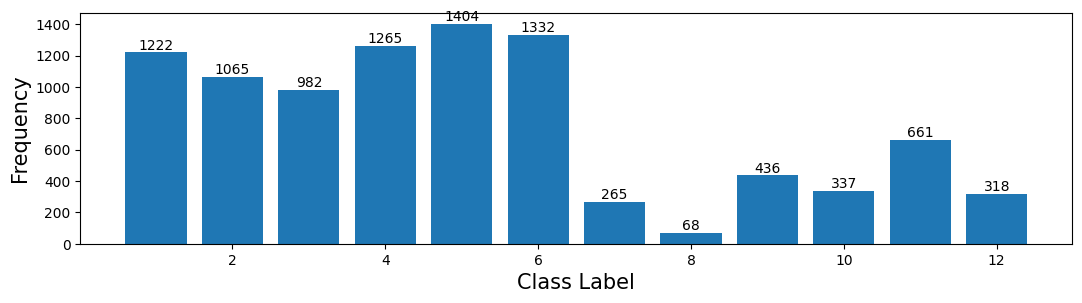

For testing data :- 
Frequencies :-  [254. 246. 207. 276. 271. 318.  54.  21.  98.  70. 121.  69.]


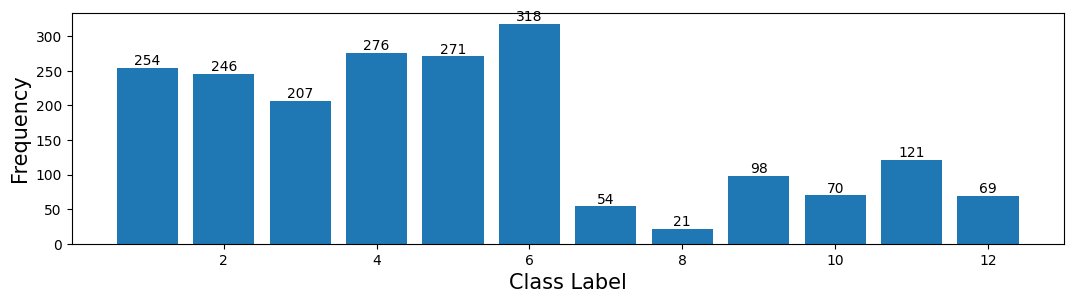

For validation data :- 
Frequencies :-  [246. 233. 218. 260. 304. 308.  56.  20.  94.  62. 129.  75.]


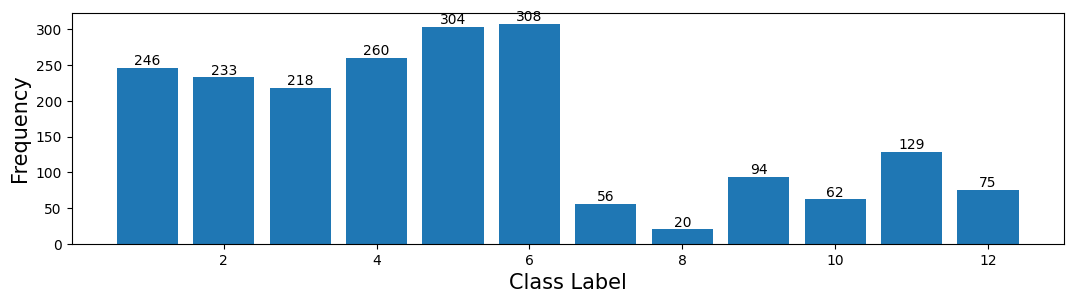

In [19]:
print('For training data :- ')
draw_bar(ytrain)
print('For testing data :- ')
draw_bar(ytest)
print('For validation data :- ')
draw_bar(yval)

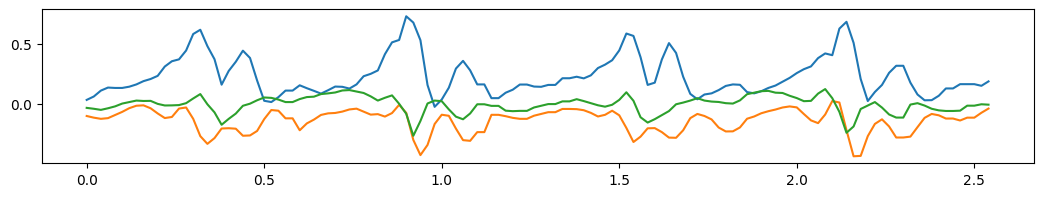

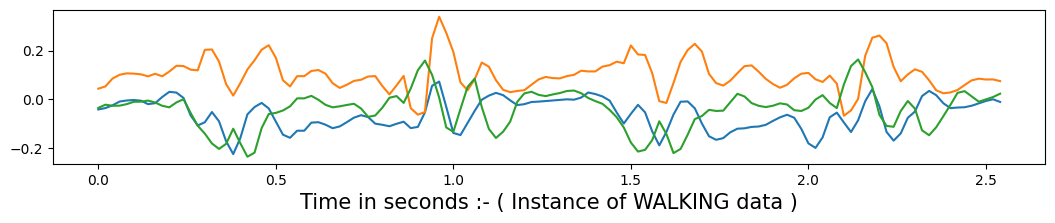

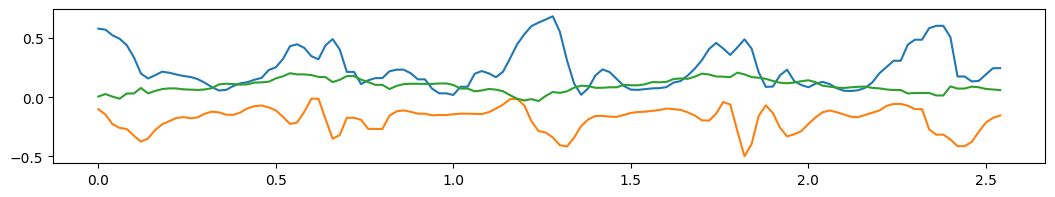

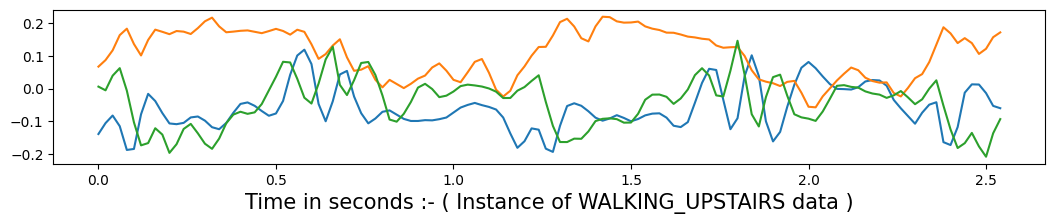

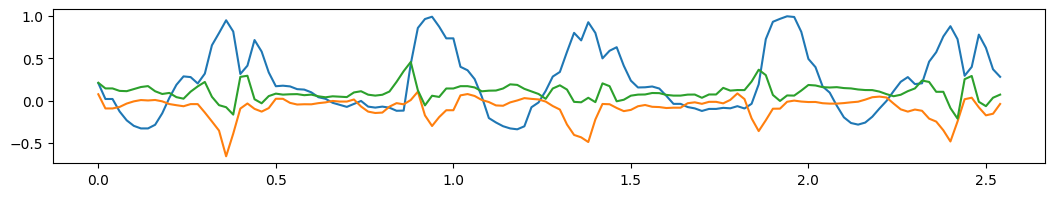

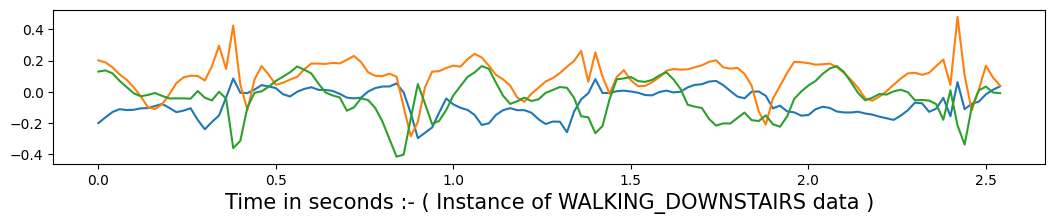

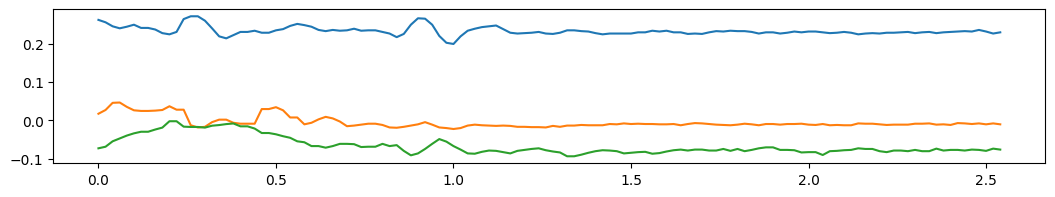

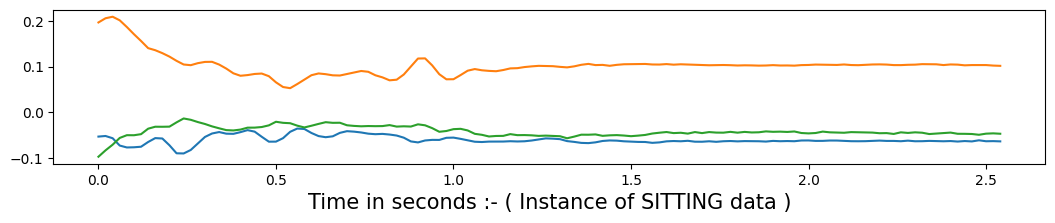

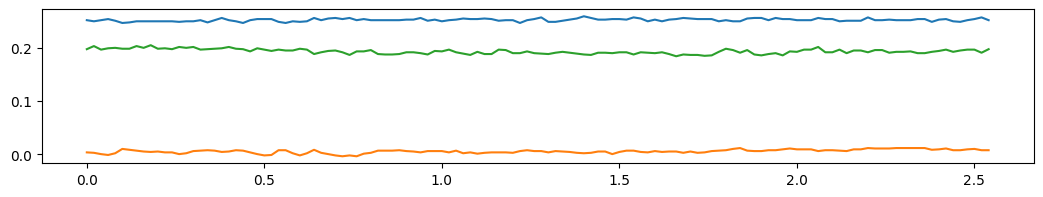

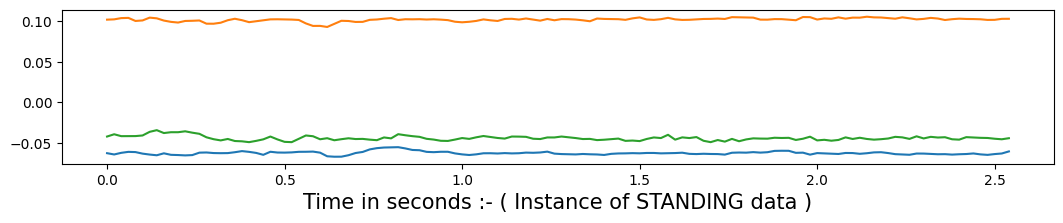

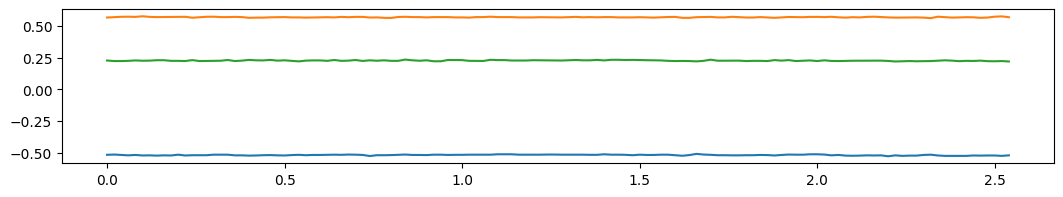

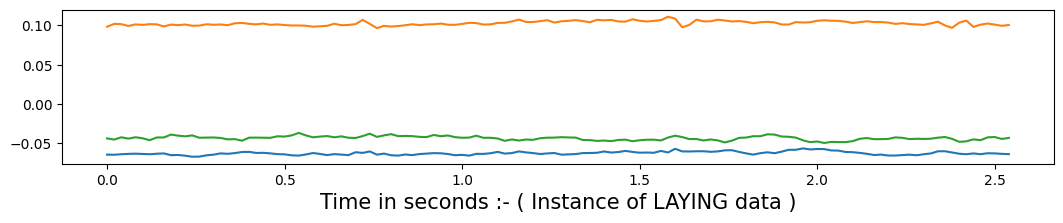

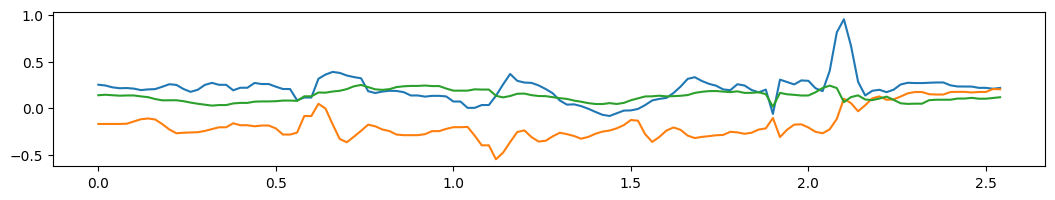

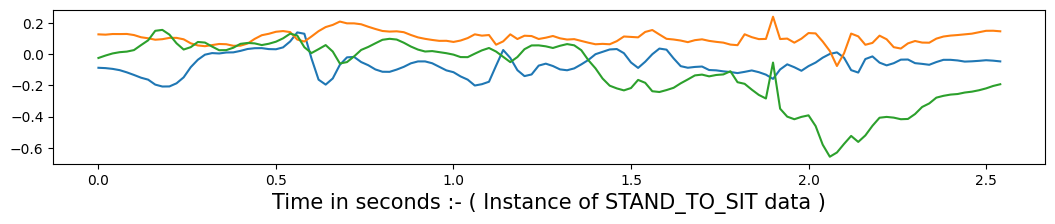

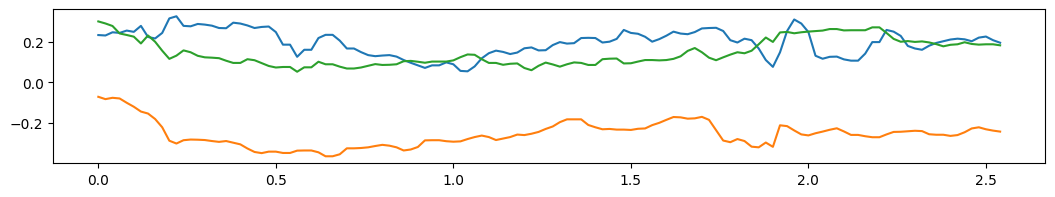

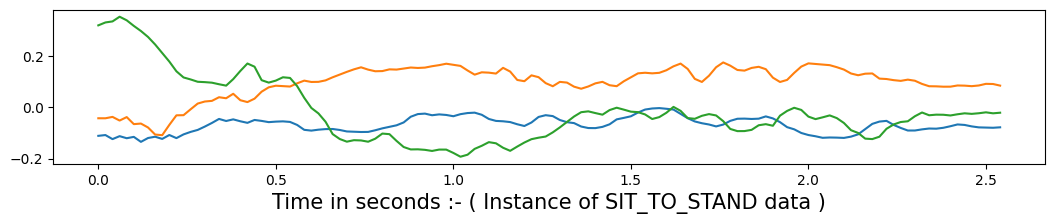

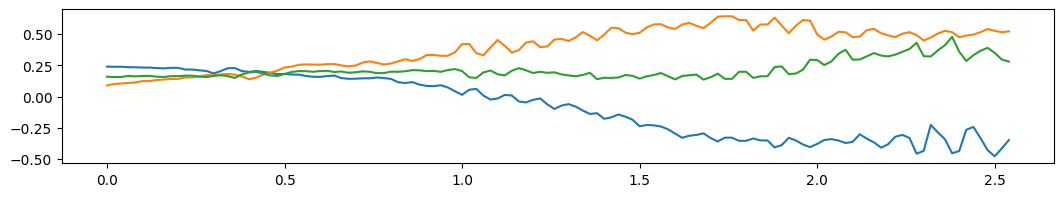

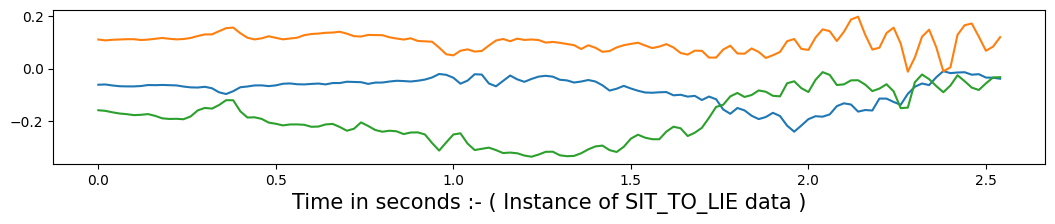

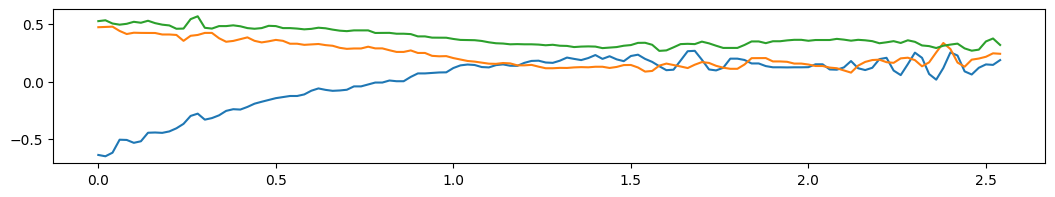

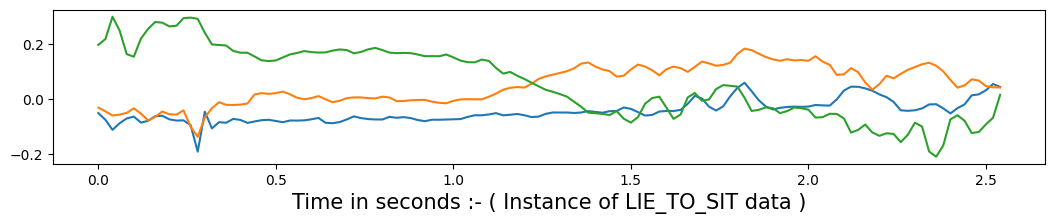

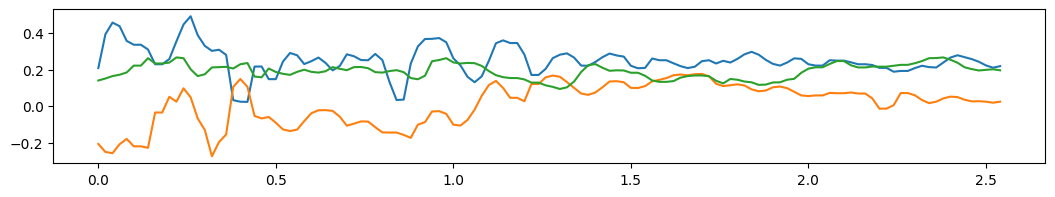

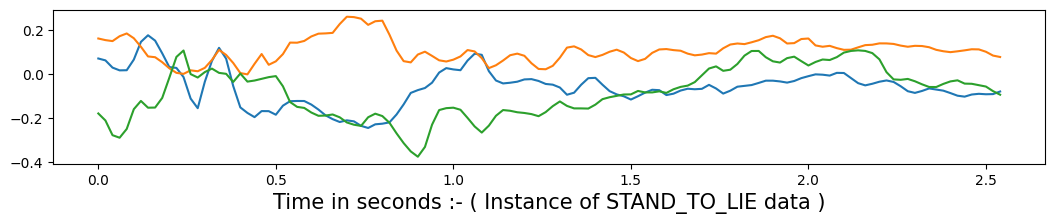

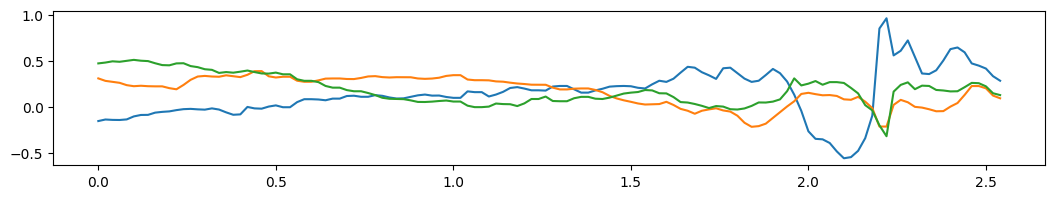

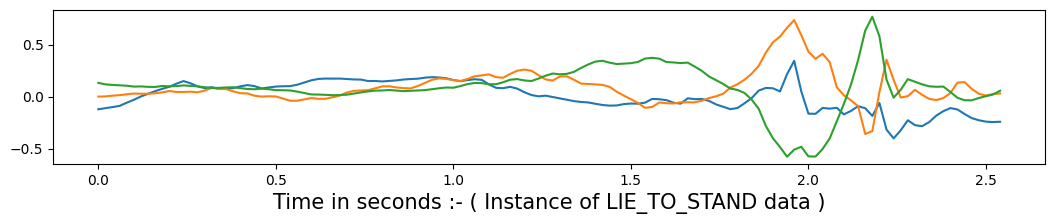

In [20]:
for i in range(12):
    draw_wave(xtrain,ytrain,i+1)    

In [21]:
#  input_shape == input_shape of each head (sensor data)
#  Here, input shape is of the form (128,3) for each head
#  seq == sequence no. of head 
#  no activations are applied after any layer ( => identity )

def cnnhead_(input_shape,seq):
    input_layer = keras.Input(shape = input_shape,name = 'title_'+str(seq))
    
    cnn = layers.Conv1D(24,2,1,"same",name = 'Conv1D_'+str(seq)+'_1')(input_layer)
    cnn = layers.LayerNormalization(name = 'layernorm_'+str(seq)+'_1')(cnn)
    cnn = layers.Dropout(rate = 0.5,name = 'dropout_'+str(seq)+'_1')(cnn)

    cnn = layers.Conv1D(48,2,1,"same",name = 'Conv1D_'+str(seq)+'_2')(cnn)
    cnn = layers.LayerNormalization(name = 'layernorm_'+str(seq)+'_2')(cnn)
    cnn = layers.Dropout(rate = 0.5,name = 'dropout_'+str(seq)+'_2')(cnn)
    
    cnn = layers.Conv1D(48,2,1,"same",name = 'Conv1D_'+str(seq)+'_3')(cnn)
    cnn = layers.LayerNormalization(name = 'layernorm_'+str(seq)+'_3')(cnn)

    return input_layer,cnn

In [22]:
# Concatenates last layer of each cnn head together in third dimension (channels)

def concatenate_(heads):
    final_layers = []
    for i,j in heads:
        final_layers.append(j)
    return layers.concatenate(final_layers,name = 'concatenate')

In [23]:
# builds last lstm block

def lstm_(input_, number_of_classes):
    x = layers.LSTM(4*number_of_classes,return_sequences = True,name = 'lstm_1')(input_)
    x = layers.LayerNormalization()(x)
    x = layers.LSTM(4*number_of_classes,return_sequences = True,name = 'lstm_2')(x)
    x = layers.LayerNormalization()(x)
    x = layers.LSTM(2*number_of_classes,name = 'lstm_3')(x)
    x = layers.LayerNormalization()(x)
    x = layers.Dense(2*number_of_classes,name = 'dense_1')(x)
    x = layers.Dense(number_of_classes,name = 'dense_2',activation = 'softmax')(x)
    return x

In [24]:
def model_(heads,dense_):
    return keras.Model([i for i,j in heads],dense_,name = 'model')

In [25]:
# xtrain is the form (row,window,sensor,axis)
# (None,128,2,3) here

def build_model( xtrain, ytrain ):
    heads = []
    
    shape = xtrain.shape
    
    for i in range(len(xtrain[0][0])):
        heads.append(cnnhead_((shape[1],shape[3]),i+1))
        
    x = concatenate_(heads)
    
    x = lstm_(x,ytrain.shape[1])

    model = model_(heads,x)
    
    return model

In [26]:
model = build_model(xtrain,ytrain)

In [28]:
# install pydot
# install graphviz

plot_model(model, "multiheaded.png",show_shapes = True,dpi=60)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
